In [342]:
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_recall_curve, precision_score, \
recall_score, f1_score, roc_curve, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

import numpy as np

import matplotlib.pylab as plt

from scipy.sparse import vstack, dok_matrix, csr_matrix, lil_matrix

import nltk 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
%matplotlib inline

In [259]:
physicians = pd.read_csv('../physicians.csv')
physicians.info()

procedures = pd.read_csv('../procedures.csv')
procedures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36025 entries, 0 to 36024
Data columns (total 2 columns):
id           36025 non-null int64
specialty    36025 non-null object
dtypes: int64(1), object(1)
memory usage: 563.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587774 entries, 0 to 587773
Data columns (total 4 columns):
physician_id          587774 non-null int64
procedure_code        587774 non-null object
procedure             587774 non-null object
number_of_patients    587774 non-null int64
dtypes: int64(2), object(2)
memory usage: 17.9+ MB


In [332]:
class ProcedureCodeFeatureExtractor(BaseEstimator, TransformerMixin):
    '''Note there are 2 ways to define feature of a procedure code:
    First Way: 1 & 0 representing if the doctor practice a procedure or not
    Second Way: 0 ~ n representing number of patients the doctor looked for a procedure
    
    This class implements the first way.
    '''
    
    def __init__(self, all_procedures_df):
        self._all_procedures_df = all_procedures_df
        proc_code_list = sorted(all_procedures_df['procedure_code'].unique())
        self.num_procedure_codes = len(proc_code_list)
        self.proc_label_binarizer = LabelBinarizer(sparse_output=True)
        self.proc_label_binarizer.fit(proc_code_list)

    def fit(self, X, y=None):
        return self
    
    def transform(self, pysicians_df, y=None):
        
        joined = pd.merge(pysicians_df[['id']], self._all_procedures_df[['physician_id','procedure_code']], 
                           left_on='id', right_on='physician_id')
        
        grouped = joined.groupby('physician_id').aggregate({'procedure_code': self._aggregate})
        
        X = vstack(grouped['procedure_code'].values)
        
        y = (pysicians_df['specialty'] == 'Cardiology').values
        
        return X, y
    
    def _aggregate(self, pcodes):
        out = sum(self.proc_label_binarizer.transform(pcodes))
        return out


In [302]:
ext = ProcedureCodeFeatureExtractor(procedures)
X = ext.fit_transform(physicians[:10])

X

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>


(<10x3140 sparse matrix of type '<class 'numpy.int64'>'
 	with 131 stored elements in Compressed Sparse Row format>,
 array([False, False, False, False, False,  True, False,  True, False,  True], dtype=bool))

In [317]:
class ProcedureTextFeatureExtractor(BaseEstimator, TransformerMixin):
    ''' 3 ways to define features:
    1. 0 & 1 - representing if the doctor's procedures contain that word
    2. 0 ~ n - representing how many times the word appears in all doctor's procedures
    3. 0 ~ n - num of times multiplied by num of patients
    
    This class implements the first way.
    
    The problem is if num of patients matter? How?
    
    '''
    
    stopwords_set = set(stopwords.words('english'))
    _tokenizer = RegexpTokenizer(r'[a-zA-Z]+')
    
    def __init__(self, all_procedures_df):
        
        self._all_procedures_df = all_procedures_df

        words = set()
        for p in all_procedures_df['procedure'].values:
            words |= self._tokenize(p)
        
        self.feature_words = list(sorted(words))
        self.num_features = len(self.feature_words)
        
        self._index_lookup = {f:index for index, f in enumerate(self.feature_words)}
    
    def _tokenize(self, procedure):
        return set(self._tokenizer.tokenize(procedure)) - self.stopwords_set

    def fit(self, X, y=None):
        return self
    
    def transform(self, pysicians_df, y=None):
        
        joined = pd.merge(pysicians_df[['id']], self._all_procedures_df[['physician_id','procedure']], 
                           left_on='id', right_on='physician_id')
        
        grouped = joined.groupby('physician_id').aggregate({'procedure': self._aggregate})
        
        X = vstack(grouped['procedure'].values)
        
        y = (pysicians_df['specialty'] == 'Cardiology').values
        
        return X, y
    
    def _aggregate(self, procedures):
        words = set()
        for p in procedures.values:
            words |= self._tokenize(p)
        
        fvec = lil_matrix((1, self.num_features),dtype=np.float32)
    
        for w in words:
            fvec[0, self._index_lookup[w]] = 1.

        return fvec.tocsr()
        

In [320]:
# split phsician data into unknown and known

# Get unknown index
_choose = ['Unknown' in specialty for specialty in physicians['specialty']]
phys_unknown = physicians[_choose]
phys_known = physicians[[not ii for ii in _choose]]

# phys_unknown.info()

In [325]:
ext = ProcedureTextFeatureExtractor(procedures)
X, y = ext.transform(phys_known)


In [333]:
ext = ProcedureCodeFeatureExtractor(procedures)
X, y = ext.transform(phys_known)

In [334]:
# Stratified shuffle-split into train and test sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    X_train = X[train_index,:]
    y_train = y[train_index]
    
    X_test = X[test_index,:]
    y_test = y[test_index]

In [335]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [336]:
cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring="accuracy")

array([ 0.96515417,  0.96515417,  0.97468037,  0.966909  ,  0.97165789])

In [337]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=5)

# calculate confusion matrix

print("Confusion Matrix: \n", confusion_matrix(y_train, y_train_pred))
print("Precision Score: ", precision_score(y_train, y_train_pred))
print("Recall Score: ", recall_score(y_train, y_train_pred))
print("F1 Score: ", f1_score(y_train, y_train_pred))

Confusion Matrix: 
 [[13160   164]
 [  460  6159]]
Precision Score:  0.974062944805
Recall Score:  0.930503097145
F1 Score:  0.951784886416


In [338]:
# Precision/Recall tradeoff

y_scores_forest = cross_val_predict(sgd_clf, X_train, y_train, cv=5, method='decision_function')

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_forest)

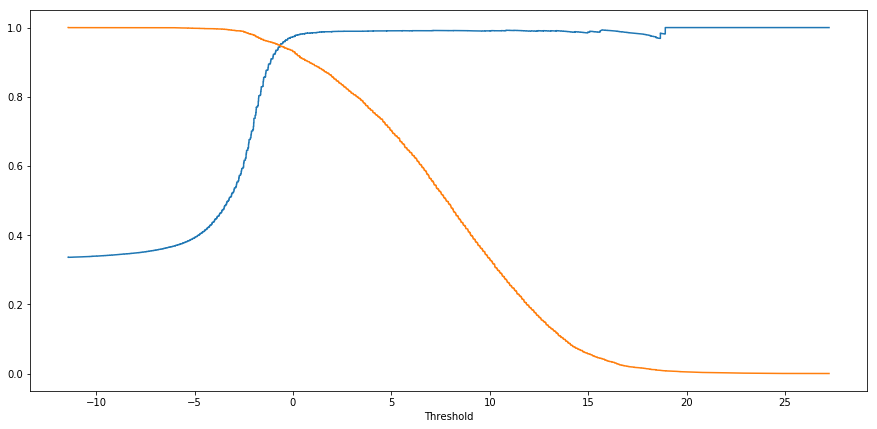

In [343]:
plt.figure(figsize=(15,7))
plt.plot(thresholds, precisions[:-1])
plt.plot(thresholds, recalls[:-1])
plt.xlabel('Threshold')